In [ ]:
本节内容：
将样本的三个变量（堵塞大小、测量误差、用户需求）进行控制变量分析。
选择测量误差作为不确定。

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as Data
from torch.optim import Adam,AdamW
from torch.optim.lr_scheduler import LambdaLR
from torch.utils.data import DataLoader
from prefetch_generator import BackgroundGenerator
import pandas as pd
import numpy as np
from tqdm import tqdm
import os
import matplotlib
import matplotlib.pyplot as plt 
import hiddenlayer as hl
from sklearn.model_selection import train_test_split,StratifiedKFold
from sklearn.decomposition import PCA
from sklearn.preprocessing import QuantileTransformer,RobustScaler
from sklearn.metrics import accuracy_score
import lightgbm as lgb
#准备文件夹保存数据
local_path=os.getcwd()
if not os.path.exists(local_path+'\\blockagedata'):
    os.mkdir(local_path+'\\blockagedata')
print(local_path+'\\blockagedata')
#判断是否可以使用GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

E:\NBCode\block\blockagedata


In [2]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import os
import matplotlib
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split,RandomizedSearchCV,GridSearchCV,StratifiedKFold,cross_validate
from sklearn.decomposition import PCA
from sklearn.preprocessing import QuantileTransformer
from sklearn.metrics import accuracy_score,confusion_matrix
from sklearn.pipeline import Pipeline
from scipy.stats import loguniform,uniform,randint
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
#准备文件夹保存数据
local_path=os.getcwd()
if not os.path.exists(local_path+'\\blockagedata'):
    os.mkdir(local_path+'\\blockagedata')
print(local_path+'\\blockagedata')

E:\NBCode\block\blockagedata


# ANN

In [3]:
class DataLoaderX(DataLoader):
    def __iter__(self):
        return BackgroundGenerator(super().__iter__())
#ANN
class ANN(nn.Module):
    def __init__(self,d1,hidden_size,d2):
        super(ANN,self).__init__()
        self.ann=nn.Sequential(nn.BatchNorm1d(d1,momentum=0.5),
                               nn.Linear(d1,hidden_size),
                               nn.LeakyReLU(),
                               nn.BatchNorm1d(hidden_size,momentum=0.5),
                               nn.Linear(hidden_size,d2),
                               nn.LeakyReLU()
                              )
    def forward(self,x):
        x = self.ann(x)
        return x
#训练模型
def anntrain(args):
    model=ANN(d1=args['d1'],hidden_size=args['hidden_size'],d2=args['d2']).to(device)
    criterion=nn.CrossEntropyLoss().to(device)
    optimizer=AdamW(model.parameters(),lr=args['learning_rate'],weight_decay=args['weight_decay'])
    scheduler=LambdaLR(optimizer,verbose=False,lr_lambda=lambda epoch:1/(epoch/100+1))
    train_loader=DataLoader(dataset=train_data,batch_size=len(x_train),
                                  shuffle=True,num_workers=0)
    history1=hl.History()
    canvas1=hl.Canvas()
    best_acc=0
    for epoch in tqdm(range(args['epoches'])):
        for step,(batch_x,batch_y) in enumerate(train_loader):
            #输出层与标签之间的误差    
            model.train()
            prediction=model(batch_x)
            loss=criterion(prediction,batch_y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            #记录误差曲线和acc曲线
            steps=epoch*len(train_loader)+step+1
            if steps%25==0:
                test_acc=score_model(x_test_tensor,y_test_tensor,model)
                best_acc=test_acc if test_acc>best_acc else best_acc
                history1.log(steps,train_loss=loss.item(),test_accuracy=test_acc)
        scheduler.step()
    with canvas1:
        canvas1.draw_plot(history1['train_loss'])
        canvas1.draw_plot(history1['test_accuracy'])
    print('train_loss:%.4f'%loss.item())
    print('test_acc:%.4f'%test_acc)
    print('best_acc:%.4f'%best_acc)
    return model,best_acc
#测试数据
def run_model(data,model):
    model.eval()
    torch.no_grad()
    prediction=model(data)
    return prediction.detach()
def score_model(x_tensor,label_tensor,model):
    x=run_model(x_tensor,model)
    x=torch.argmax(x,1).unsqueeze(1)
    score=(x==label_tensor).sum().item()/len(x)
    return score

## 得到模型

In [7]:
#读取模型数据
sample=pd.read_csv(local_path+'\\blockagedata\\Sample_116.csv',header=0)
#划分样本和标签
s1=sample.iloc[np.where(sample.loc[:,'dn']==1)[0],:]
s2=sample.iloc[np.where(sample.loc[:,'dn']==2)[0],:]
s3=sample.iloc[np.where(sample.loc[:,'dn']==3)[0],:]
s4=sample.iloc[np.where(sample.loc[:,'dn']==4)[0],:]
s5=sample.iloc[np.where(sample.loc[:,'dn']==5)[0],:]
s6=sample.iloc[np.where(sample.loc[:,'dn']==6)[0],:]
s7=sample.iloc[np.where(sample.loc[:,'dn']==7)[0],:]
s8=sample.iloc[np.where(sample.loc[:,'dn']==8)[0],:]
s9=sample.iloc[np.where(sample.loc[:,'dn']==9)[0],:]
err=0.05
ts1=s9.iloc[np.where(s9.loc[:,'time']==6)[0],:]
ts2=s9.iloc[np.where(s9.loc[:,'time']==12)[0],:]
ts3=s9.iloc[np.where(s9.loc[:,'time']==17)[0],:]
ts10=pd.concat([ts1,ts2,ts3,ts1,ts2,ts3,ts1,ts2,ts3,ts1,ts2,ts3,ts1,ts2,ts3],axis=0)
np.random.seed(1)
ts10_err=ts10.iloc[:,range(96)]*np.random.normal(loc=1,scale=err,size=(1740,96))

In [8]:
ts10.shape

(1740, 99)

In [66]:
for i in range(24):
    s=sample.iloc[np.where(sample.loc[:,'time']==i)[0],:]
    for j in range(1,10):
        t=s.iloc[np.where(s.loc[:,'dn']==j)[0],:]
        if len(t)==116:
            print(i,j)

0 4
0 5
0 6
0 7
0 8
0 9
1 3
1 4
1 5
1 6
1 7
1 8
1 9
2 3
2 4
2 5
2 6
2 7
2 8
2 9
3 3
3 4
3 5
3 6
3 7
3 8
3 9
4 3
4 4
4 5
4 6
4 7
4 8
4 9
5 3
5 4
5 5
5 6
5 7
5 9
6 3
6 4
6 5
6 6
6 8
6 9
7 5
7 7
7 8
7 9
8 3
8 5
8 7
8 8
8 9
9 3
9 5
9 6
9 7
9 8
9 9
10 3
10 5
10 6
10 7
10 9
11 3
11 5
11 7
11 8
11 9
12 3
12 5
12 6
12 7
12 8
12 9
13 3
13 4
13 5
13 6
13 7
13 8
13 9
14 3
14 4
14 5
14 6
14 7
14 8
14 9
15 3
15 4
15 5
15 6
15 7
15 8
15 9
16 3
16 4
16 5
16 6
16 7
16 8
16 9
17 3
17 4
17 5
17 6
17 8
17 9
18 5
18 8
18 9
19 3
19 8
19 9
20 3
20 7
20 8
20 9
21 3
21 5
21 7
21 8
21 9
22 3
22 4
22 5
22 6
22 7
22 8
22 9
23 3
23 4
23 5
23 6
23 7
23 9


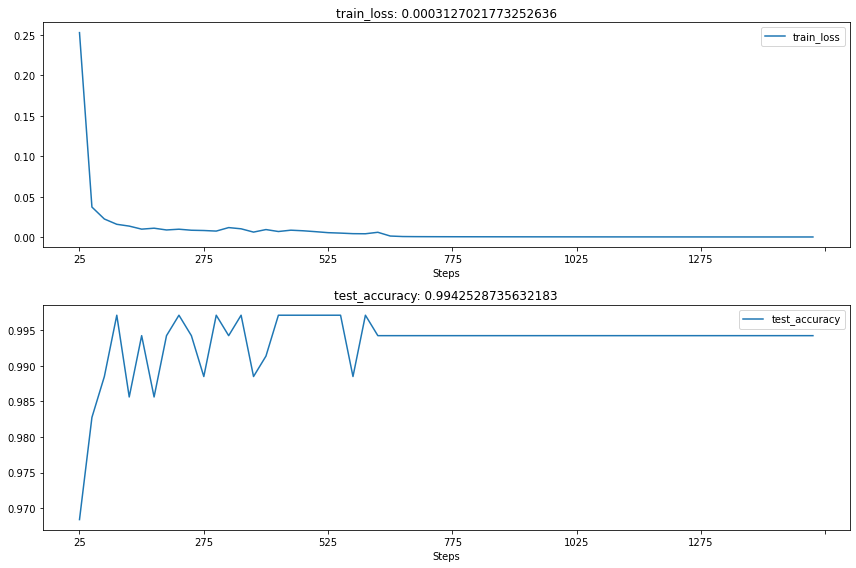

train_loss:0.0003
test_acc:0.9943
best_acc:0.9971
train_acc: 1.0
acc: [1.0, 0.9971264367816092, 0.9971264367816092, 0.9971264367816092, 0.9971264367816092]
ave_acc 0.9977011494252874
score_record: [0.9977011494252874]
hs_record: [110]


In [19]:
#划分样本和标签
x=np.array(ts10_err)#.astype(int)
y=np.array(ts10.loc[:,'code']).reshape(-1,1).astype(int)
#训练模型
skf = StratifiedKFold(n_splits=5,shuffle=True,random_state=1)
score_record=[]
hs_record=[]
for hs in range(110,120,10):
    params={
    "d1":96,
    "hidden_size": hs,
    "d2":116,
    "learning_rate":0.01,
    "epoches":1500,
    "weight_decay":0.01
    }
    acc=[]
    for train_index, test_index in skf.split(x,y):
        x_train, x_test = x[train_index], x[test_index]
        y_train, y_test = y[train_index], y[test_index]
        #qt
        qt = QuantileTransformer(output_distribution = 'uniform' )
        x_train = qt.fit_transform(x_train)
        x_test = qt.transform(x_test)
        #numpy转为张量
        x_train_tensor=torch.from_numpy(x_train).float().to(device)
        y_train_tensor=torch.from_numpy(y_train).to(device)
        x_test_tensor=torch.from_numpy(x_test).float().to(device)
        y_test_tensor=torch.from_numpy(y_test).to(device)
        train_data=Data.TensorDataset(x_train_tensor,y_train_tensor.long().squeeze())
        annmodel,best_acc=anntrain(params)
        train_acc=score_model(x_train_tensor,y_train_tensor,annmodel)
        print('train_acc:',train_acc)
        acc.append(best_acc)
        print('acc:',acc)
    ave_score=np.mean(acc)
    print('ave_acc',ave_score)
    score_record.append(ave_score)
    hs_record.append(hs)
    print('score_record:',score_record)
    print('hs_record:',hs_record)

## 处理结果

In [ ]:
torch.save(annmodel.state_dict(),local_path+'\\blockagedata\\annmodel_hid110.pkl')
# model = TheModelClass(...)
# model.load_state_dict(torch.load('\parameter.pkl'))

In [ ]:
# model = TheModelClass(...)
# model.load_state_dict(torch.load('\parameter.pkl'))
pre=run_model(x_test_tensor,annmodel)
pre=torch.argmax(pre,1).unsqueeze(1).cpu().numpy()
bool1=np.ones([len(pre),1])
bool1[np.where(pre.ravel()!=y_test.ravel())]=0
pred=pd.DataFrame(pre)
S=sample.loc[test_index,:]
para=S.iloc[:,range(96,99)].reset_index()
bool2=pd.DataFrame(bool1.astype(int))
a=pd.concat([pred,para,bool2],axis=1,ignore_index=True)
a.columns=['pred','index','true','dn','time','bool']
a=a[['index','pred','true','dn','time','bool']]
a.to_csv(local_path+'\\blockagedata\\ann_hid110_test_result.csv',encoding='ascii',index=True)

In [ ]:
from sklearn.metrics import accuracy_score,confusion_matrix
cm=pd.DataFrame(confusion_matrix(y_test.ravel(),pre))
cm.to_csv(local_path+'\\blockagedata\\ann_hid110_cm.csv',encoding='ascii',index=True)

# SVM

In [20]:
#划分样本和标签
x=np.array(ts10_err)#.astype(int)
y=np.array(ts10.loc[:,'code']).reshape(-1,1).astype(int)
#训练模型
skf = StratifiedKFold(n_splits=5,shuffle=True,random_state=1)
score_record=[]
hs_record=[]
acc=[]
for train_index, test_index in skf.split(x,y):
    x_train, x_test = x[train_index], x[test_index]
    y_train, y_test = y[train_index], y[test_index]
    #qt
    qt = QuantileTransformer(output_distribution = 'uniform' )
    x_train = qt.fit_transform(x_train)
    x_test = qt.transform(x_test)
    clf=SVC(decision_function_shape='ovr',kernel='rbf',C=500000,gamma=0.06)
    clf.fit(x_train,y_train.ravel())
    best_acc=clf.score(x_test,y_test.ravel())
    train_acc=clf.score(x_train,y_train.ravel())
    print('train_acc:',train_acc)
    acc.append(best_acc)
    print('acc:',acc)
ave_score=np.mean(acc)
print('ave_acc',ave_score)
score_record.append(ave_score)
print('score_record:',score_record)

train_acc: 1.0
acc: [1.0]
train_acc: 1.0
acc: [1.0, 0.9971264367816092]
train_acc: 1.0
acc: [1.0, 0.9971264367816092, 0.9971264367816092]
train_acc: 1.0
acc: [1.0, 0.9971264367816092, 0.9971264367816092, 0.9942528735632183]
train_acc: 1.0
acc: [1.0, 0.9971264367816092, 0.9971264367816092, 0.9942528735632183, 1.0]
ave_acc 0.9977011494252874
score_record: [0.9977011494252874]


In [ ]:
#读取模型数据
sample=pd.read_csv(local_path+'\\blockagedata\\Sample_116.csv',header=0)
#划分样本和标签
x=np.array(sample.iloc[:,range(0,96)])#.astype(int)
y=np.array(sample.loc[:,'code']).reshape(-1,1).astype(int)

In [ ]:
pipe = Pipeline([('scaler', QuantileTransformer(output_distribution = 'uniform')), ('svc', SVC(decision_function_shape='ovr',kernel='rbf'))])
param_dist = {'svc__C': [1,10,100,1000,10000,100000,500000,800000,1000000,1200000,1500000],
 'svc__gamma': [0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.01]}
splitter=StratifiedKFold(n_splits=5,random_state=1,shuffle=True)
clf = GridSearchCV(estimator=pipe,param_grid=param_dist,cv=splitter,n_jobs=-1,scoring='accuracy',verbose=3)
search = clf.fit(x, y.ravel())

In [ ]:
print('网格搜索-度量记录：',search.cv_results_)  # 包含每次训练的相关信息
print('网格搜索-最佳度量值:',search.best_score_)  # 获取最佳度量值
print('网格搜索-最佳参数：',search.best_params_)  # 获取最佳度量值时的代定参数的值。是一个字典
print('网格搜索-最佳模型：',search.best_estimator_)  # 获取最佳度量时的分类器模型

In [ ]:
xx=search.cv_results_['param_svc__C'].data.astype(float)
yy=search.cv_results_['param_svc__gamma'].data.astype(float)
zz=search.cv_results_['mean_test_score'].astype(float)
xx=np.expand_dims(xx,axis=1)
yy=np.expand_dims(yy,axis=1)
zz=np.expand_dims(zz,axis=1)
print(xx.shape)
print(yy.shape)
print(zz.shape)
zxc=pd.DataFrame(np.hstack((xx,yy,zz)))
zxc.columns=['C','gamma','acc']
zxc=pd.pivot_table(zxc,index=['C'],columns=['gamma'],values=['acc'])
zxc.to_csv(local_path+'\\blockagedata\\svm_finetune_grid_b.csv',encoding='ascii',index=True)

In [ ]:
zxc=pd.DataFrame(np.hstack((xx,yy,zz)))
zxc.columns=['C','gamma','acc']
a=pd.pivot_table(zxc,index=['C'],columns=['gamma'],values=['acc'])
a.to_csv(local_path+'\\blockagedata\\svm_finetune_grid_a.csv',encoding='ascii',index=False)

# RF

In [21]:
#划分样本和标签
x=np.array(ts10_err)#.astype(int)
y=np.array(ts10.loc[:,'code']).reshape(-1,1).astype(int)
#训练模型
skf = StratifiedKFold(n_splits=5,shuffle=True,random_state=1)
score_record=[]
hs_record=[]
acc=[]
for train_index, test_index in skf.split(x,y):
    x_train, x_test = x[train_index], x[test_index]
    y_train, y_test = y[train_index], y[test_index]
    #qt
    qt = QuantileTransformer(output_distribution = 'uniform' )
    x_train = qt.fit_transform(x_train)
    x_test = qt.transform(x_test)
    clf=RandomForestClassifier(n_estimators=100,criterion='gini',max_depth=None,min_samples_split=2,n_jobs=-1)
    clf.fit(x_train,y_train.ravel())
    best_acc=clf.score(x_test,y_test.ravel())
    train_acc=clf.score(x_train,y_train.ravel())
    print('train_acc:',train_acc)
    acc.append(best_acc)
    print('acc:',acc)
ave_score=np.mean(acc)
print('ave_acc',ave_score)
score_record.append(ave_score)
print('score_record:',score_record)

train_acc: 1.0
acc: [1.0]
train_acc: 1.0
acc: [1.0, 1.0]
train_acc: 1.0
acc: [1.0, 1.0, 1.0]
train_acc: 1.0
acc: [1.0, 1.0, 1.0, 1.0]
train_acc: 1.0
acc: [1.0, 1.0, 1.0, 1.0, 0.9971264367816092]
ave_acc 0.9994252873563217
score_record: [0.9994252873563217]


In [ ]:
pipe = Pipeline([('scaler', QuantileTransformer(output_distribution = 'uniform')), ('rfc', RandomForestClassifier(criterion='gini',))])
param_dist = {'rfc__n_estimators': randint(10, 500),
 'rfc__min_samples_split': randint(2, 1000),
 'rfc__max_depth': randint(2, 100)}
splitter=StratifiedKFold(n_splits=5,random_state=1,shuffle=True)
clf = RandomizedSearchCV(estimator=pipe,param_distributions=param_dist,n_iter=10,cv=splitter,random_state=11,n_jobs=-1,scoring='accuracy',verbose=3)
search = clf.fit(x, y.ravel())

# KNN

In [22]:
#划分样本和标签
x=np.array(ts10_err)#.astype(int)
y=np.array(ts10.loc[:,'code']).reshape(-1,1).astype(int)
#训练模型
skf = StratifiedKFold(n_splits=5,shuffle=True,random_state=1)
score_record=[]
hs_record=[]
acc=[]
for train_index, test_index in skf.split(x,y):
    x_train, x_test = x[train_index], x[test_index]
    y_train, y_test = y[train_index], y[test_index]
    #qt
    qt = QuantileTransformer(output_distribution = 'uniform' )
    x_train = qt.fit_transform(x_train)
    x_test = qt.transform(x_test)
    clf=KNeighborsClassifier(n_neighbors=1)
    clf.fit(x_train,y_train.ravel())
    best_acc=clf.score(x_test,y_test.ravel())
    train_acc=clf.score(x_train,y_train.ravel())
    print('train_acc:',train_acc)
    acc.append(best_acc)
    print('acc:',acc)
ave_score=np.mean(acc)
print('ave_acc',ave_score)
score_record.append(ave_score)
print('score_record:',score_record)

train_acc: 1.0
acc: [0.985632183908046]
train_acc: 1.0
acc: [0.985632183908046, 0.9827586206896551]
train_acc: 1.0
acc: [0.985632183908046, 0.9827586206896551, 0.9913793103448276]
train_acc: 1.0
acc: [0.985632183908046, 0.9827586206896551, 0.9913793103448276, 0.9827586206896551]
train_acc: 1.0
acc: [0.985632183908046, 0.9827586206896551, 0.9913793103448276, 0.9827586206896551, 0.9942528735632183]
ave_acc 0.9873563218390805
score_record: [0.9873563218390805]


In [ ]:
pipe = Pipeline([('scaler', QuantileTransformer(output_distribution = 'uniform')), ('knn', KNeighborsClassifier())])
param_dist = {'knn__n_neighbors': [1,2,3,4,5,6,7,8,9]}
splitter=StratifiedKFold(n_splits=5,random_state=1,shuffle=True)
clf = RandomizedSearchCV(estimator=pipe,param_distributions=param_dist,n_iter=9,cv=splitter,random_state=1,n_jobs=-1,scoring='accuracy',verbose=3)
search = clf.fit(x, y.ravel())

In [ ]:
print('网格搜索-度量记录：',search.cv_results_)  # 包含每次训练的相关信息
print('网格搜索-最佳度量值:',search.best_score_)  # 获取最佳度量值
print('网格搜索-最佳参数：',search.best_params_)  # 获取最佳度量值时的代定参数的值。是一个字典
print('网格搜索-最佳模型：',search.best_estimator_)  # 获取最佳度量时的分类器模型

In [ ]:
xx=search.cv_results_['param_knn__n_neighbors'].data.astype(float)
zz=search.cv_results_['mean_test_score'].astype(float)
xx=np.expand_dims(xx,axis=1)
zz=np.expand_dims(zz,axis=1)
print(xx.shape)
print(zz.shape)
zxc=pd.DataFrame(np.hstack((xx,zz)))
zxc.columns=['k','acc']
# zxc=pd.pivot_table(zxc,index=['C'],columns=['gamma'],values=['acc'])
# zxc.to_csv(local_path+'\\blokagedata\\svm_finetune_grid_b.csv',encoding='ascii',index=True)